## Librerías

In [1]:
import pandas as pd
import numpy as np
import pygal
import seaborn as sns
import matplotlib.pyplot as plt
import os
from functools import reduce
%matplotlib inline

## Lista de archivos

In [2]:
ruta = '/home/jose/data/chicago/'
lst_arch = [x for x in os.listdir(ruta) if x[:3]=='chi']

## Lectura de archivos

In [3]:
%%time
for i,arch in enumerate(lst_arch):
    print(arch)
    aux = pd.read_csv(os.path.join(ruta,arch))[['trip_start_timestamp','taxi_id','trip_total','payment_type','tips']]
    if i == 0:
        df = aux.copy()
    else:
        df = pd.concat([df,aux],ignore_index=True)

chicago_taxi_trips_2016_01.csv
chicago_taxi_trips_2016_02.csv
chicago_taxi_trips_2016_03.csv
chicago_taxi_trips_2016_04.csv
chicago_taxi_trips_2016_05.csv
chicago_taxi_trips_2016_06.csv
chicago_taxi_trips_2016_07.csv
chicago_taxi_trips_2016_08.csv
chicago_taxi_trips_2016_09.csv
chicago_taxi_trips_2016_10.csv
chicago_taxi_trips_2016_11.csv
chicago_taxi_trips_2016_12.csv
CPU times: user 35.3 s, sys: 2.49 s, total: 37.8 s
Wall time: 42.7 s


## Muestra para experimentos (para que no se tarde)

In [4]:
aux = pd.DataFrame({'taxi_id':df.taxi_id.unique()})

In [5]:
aux = aux.sample(frac=0.1)

In [6]:
mini_df = df.merge(aux,on='taxi_id',how='inner')

In [8]:
mini_df.shape

(1980427, 5)

## Visualización Monto y # de viajes por mes y por medio de pago

In [9]:
df['fh'] = pd.to_datetime(df.trip_start_timestamp).dt.date.map(lambda x:x.strftime('%Y%m'))

In [10]:
aux = df[['fh','payment_type','trip_total']].copy()

In [11]:
aux['n'] = 1

In [12]:
aux.head()

fh payment_type  trip_total  n
0  201601         Cash        4.50  1
1  201601  Credit Card        8.90  1
2  201601  Credit Card       47.75  1
3  201601         Cash        7.00  1
4  201601         Cash       10.25  1

In [13]:
aux_mes = aux.drop('payment_type',axis=1).groupby('fh').sum()
aux_mes.trip_total/=10**6
aux_mes['n']/=10**6
aux_mes.head()

trip_total         n
fh                          
201601   26.647381  1.705805
201602   27.583271  1.751192
201603   32.212161  1.975108
201604   32.718462  1.952152
201605   33.911636  1.943584

In [14]:
chart = pygal.Line()
chart.title = 'Histórico (cifras en millones)'
chart.add('Monto', aux_mes.trip_total)
chart.add('#Viajes', aux_mes['n'], secondary=True)
chart.render_to_file('g_por_mes.svg')

In [15]:
aux_mp = aux.drop('fh',axis=1).groupby('payment_type').sum()
aux_mp.trip_total/=10**6
aux_mp['n']/=10**6
aux_mp.head()

trip_total          n
payment_type                       
Cash          130.255602  10.449095
Credit Card   197.572321   9.258402
Dispute         0.181248   0.011948
No Charge       1.798016   0.099817
Pcard           0.053130   0.005250

In [16]:
chart = pygal.Bar()
chart.title = '$Total de viajes (mdd)'
chart.x_labels = aux_mp.index
chart.add('$', aux_mp.trip_total)
chart.render_to_file('g_por_mp_1.svg')

In [17]:
chart = pygal.Bar()
chart.title = '#Total de viajes (millones)'
chart.x_labels = aux_mp.index
chart.add('$', aux_mp['n'])
chart.render_to_file('g_por_mp_2.svg')

## Tabla para las semanas

In [25]:
mini_df['w'] = pd.to_datetime(mini_df.trip_start_timestamp).dt.date.map(lambda x:x.strftime('%U')).astype(int)

In [29]:
mini_df.head()

trip_start_timestamp  taxi_id  trip_total payment_type  tips  w
0    2016-1-3 07:45:00   6078.0        9.00         Cash   0.0  1
1   2016-1-22 21:15:00   6078.0        3.25         Cash   0.0  3
2    2016-1-1 19:15:00   6078.0        8.25         Cash   0.0  0
3    2016-1-3 21:30:00   6078.0        9.75  Credit Card   3.0  1
4   2016-1-22 18:15:00   6078.0        5.50         Cash   0.0  3

In [30]:
%%time
cols = ['trip_total','tips']
lst = []
for k in range(11,52+1):
    print(k)
    aux = mini_df[(mini_df.w>=(k-11)&(mini_df.w<=k))].copy()
    aux.reset_index(drop=True,inplace=True)
    lst_pz = []
    i=1
    for j in range(k,k-12,-1):
        ax = aux[aux.w==j].drop(['w','trip_start_timestamp','payment_type'],axis=1)
        ax.reset_index(drop=True,inplace=True)
        ax.rename(columns=dict(zip(cols,['%s_%d'%(c,i) for c in cols])),inplace=True)
        ax = ax.groupby('taxi_id').sum().reset_index()
        lst_pz.append(ax)  
        i+=1
    ax = reduce(lambda x,y:pd.merge(x,y,on='taxi_id',how='outer'),lst_pz)
    for c in cols:
        ax['media_%s_12'%c] = ax[['%s_%d'%(c,i) for i in range(1,13)]].mean(axis=1)
    ax = ax[[c for c in ax.columns if c.startswith('media') or c=='taxi_id']]
    ax['w'] = k
    lst.append(ax) 

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
CPU times: user 18.9 s, sys: 224 ms, total: 19.1 s
Wall time: 19.1 s


In [32]:
final = pd.concat(lst,ignore_index=True)

In [33]:
final.shape

(25693, 4)

In [34]:
final.head()

taxi_id  media_trip_total_12  media_tips_12   w
0     24.0            48.573333       0.257778  11
1     33.0           705.246667     112.609167  11
2    101.0          1484.301667     145.604167  11
3    109.0          1024.211667     104.345000  11
4    121.0           896.878000      72.676000  11

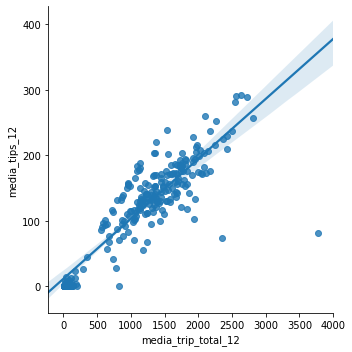

In [51]:
sns.lmplot(data=final.sample(frac=0.01),x='media_trip_total_12',y='media_tips_12',fit_reg=True)

In [45]:
final.loc[final.taxi_id==109][['media_trip_total_12','media_tips_12']].corr()

media_trip_total_12  media_tips_12
media_trip_total_12             1.000000       0.905637
media_tips_12                   0.905637       1.000000

## Densidades 

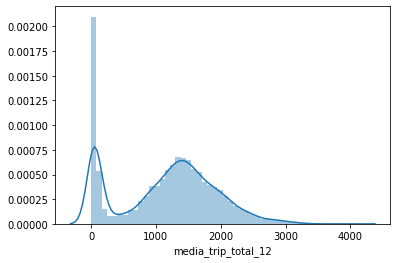

In [53]:
sns.distplot(final['media_trip_total_12'],hist=True)

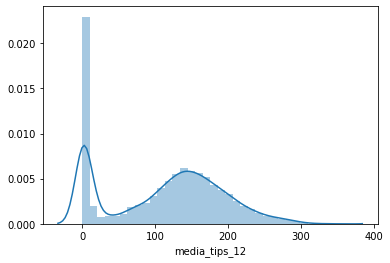

In [54]:
sns.distplot(final['media_tips_12'],hist=True)